# Week 2 Lecture 1 - Bayesian coding

McElreath's lectures for the whole book are available here: https://github.com/rmcelreath/stat_rethinking_2022

An excellent port to Python/PyMC Code is available here: https://github.com/dustinstansbury/statistical-rethinking-2023

You are encouraged to work through both of these versions to re-enforce what we're doing in class.

In [2]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import random as rd
import pymc as pm
from matplotlib import cm

from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Kalahari foragers example

Let's import the Nancy Howell's data from the Kalahari people and take a look:

In [3]:
# Import data
xdata = pd.read_csv('../Data/howell.csv')
# Display top 5 rows
xdata.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
# Table of descriptive statistics
xdata.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


In [5]:
# Remove kids from dataframe
kdata = xdata.loc[xdata.age >  17]
kdata.describe().T

,count,mean,std,min,25%,50%,75%,max
height,352.0,154.597093,7.742332,136.525000,148.59000,154.30500,160.655000,179.070000
weight,352.0,44.990486,6.456708,31.071052,40.25629,44.79221,49.292693,62.992589
age,352.0,41.138494,15.967855,18.000000,28.00000,39.00000,51.000000,88.000000
male,352.0,0.468750,0.499733,0.000000,0.00000,0.00000,1.000000,1.000000


As a first example, let's take a look at the distribution of the data

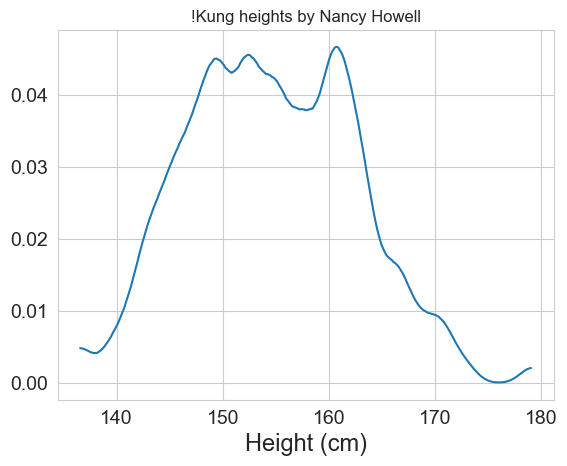

In [6]:
# Use pymc3 plotting features to plot the distribution of adult heights
pm.plot_kde(kdata.height.values)
plt.xlabel('Height (cm)', fontsize=17)
plt.title('!Kung heights by Nancy Howell')
plt.savefig('kungheight.jpg', dpi=200);

We can start our model with a basic (null) model, using a normal distribution to summarize the distribution of adult heights:

$$
\large{
h_i \sim Normal(\mu,\sigma)
}
$$


This describes the likelihood (or data distribution) part of the model, which being normal has two parameters that need priors:

$$
\large{
\begin{align*}
h_i &\sim Normal(\mu,\sigma) \\
\mu &\sim Normal(178, 20) \\
\sigma &\sim Uniform(0, 50)
\end{align*}}
$$

or again, more succinctly,

$$
\large{
\begin{align*}
h_i &\sim N(\mu,\sigma) \\
\mu &\sim N(178, 20) \\
\sigma &\sim U(0, 50)
\end{align*}}
$$

We can plot the distribution of these priors to see what they assume:

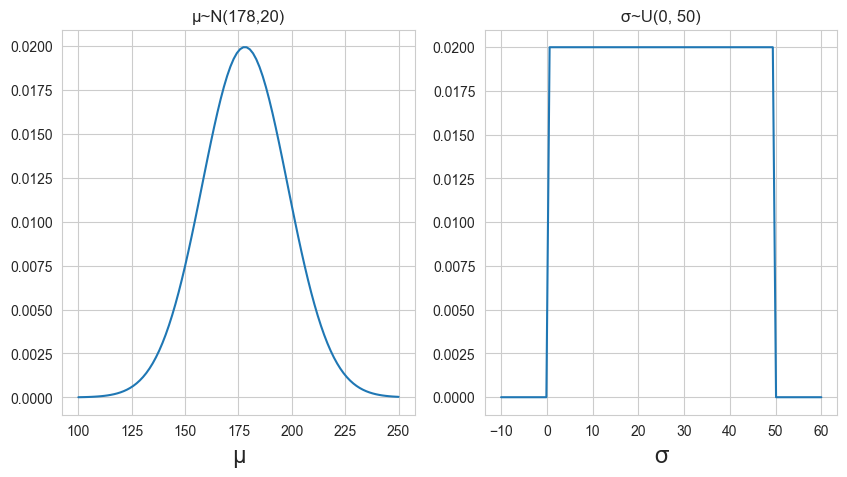

In [7]:
# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of normal prior
x = np.linspace(100, 250, 100)
ax_[0].plot(x, sp.stats.norm.pdf(x, 178, 20))
ax_[0].set_xlabel('μ', fontsize=17)
ax_[0].set_title('μ~N(178,20)')

# Plot range of sigma prior
x = np.linspace(-10, 60, 100)
ax_[1].plot(x, sp.stats.uniform.pdf(x, 0, 50))
ax_[1].set_xlabel('σ', fontsize=17)
ax_[1].set_title('σ~U(0, 50)')

plt.savefig('kungpriors.jpg', dpi=200);


So now we have a model - a likelihood and some priors - from which we can simulate, even though we have yet to see any data. To do this, we'll draw 1000 samples from our priors, then fire them into a normal and store the value at each iteration:


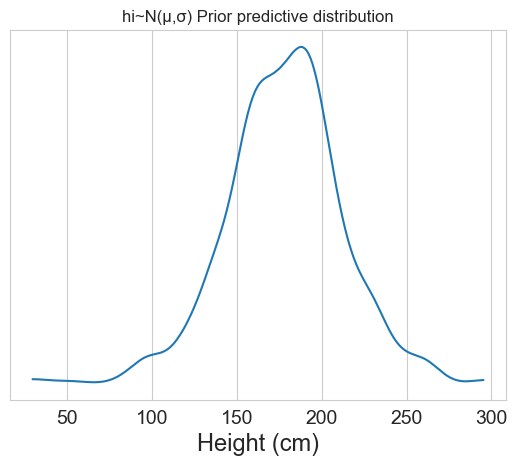

In [8]:
# Number of samples
nsamp = 1000
# Grab samples from 
mu_ = np.random.normal(178, 20, nsamp)
sigma_ = np.random.uniform(0, 50, nsamp)
h_ = np.random.normal(mu_, sigma_)
pm.plot_kde(h_)
plt.xlabel('Height (cm)', fontsize=17)
plt.yticks([])
plt.title('hi~N(μ,σ) Prior predictive distribution')
plt.savefig('kungpriorsim.jpg', dpi=200);

What this gives us is some idea about how realistic our results are in terms of the **a priori** allowable height values for adults. Are these reasonable? Well we could add lines to indicate some known information - the tallest ever person ([Robert Wadlow](https://en.wikipedia.org/wiki/Robert_Wadlow)) who topped out at 272 cm:

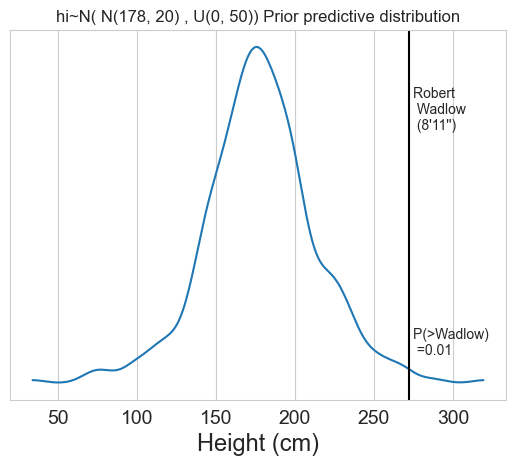

In [9]:
# Number of samples
nsamp = 1000
# Grab samples from 
mu_ = np.random.normal(178, 20, nsamp)
sigma_ = np.random.uniform(0, 50, nsamp)
h_ = np.random.normal(mu_, sigma_)
pm.plot_kde(h_)
plt.xlabel('Height (cm)', fontsize=17)
plt.axvline(x=272, c='black')
#plt.yticks([])
plt.text(275, 0.010, "Robert \n Wadlow \n (8'11'')")
plt.title('hi~N( N(178, 20) , U(0, 50)) Prior predictive distribution')
plt.text(275, 0.0011, "P(>Wadlow) \n =0.01")
plt.yticks([])
plt.savefig('kungpriorsim2.jpg', dpi=200);

Which amounts to 1.3% percent of our a priori people being taller than the tallest ever person:

In [10]:
sum(h_>272)/len(h_)

0.005

What about those wide 'uninformative' priors I've heard so much about? Well, this poses a problem for heights, which by definition can't go below zero. If we use an $N(178,1000)$ prior, this is what happens:

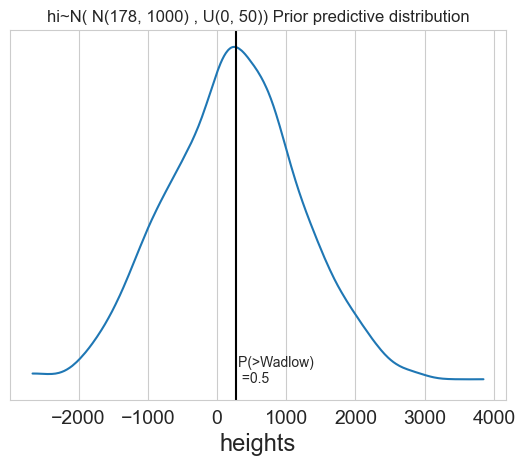

In [11]:
# Number of samples
nsamp = 1000
# Grab samples from 
mu_ = np.random.normal(178, 1000, nsamp)
sigma_ = np.random.uniform(0, 50, nsamp)
h_ = np.random.normal(mu_, sigma_)
pm.plot_kde(h_)
plt.xlabel('heights', fontsize=17)
plt.axvline(x=272, c='black')
#plt.text(275, 0.010, "Robert \n Wadlow \n (8'11'')")
plt.title('hi~N( N(178, 1000) , U(0, 50)) Prior predictive distribution')
plt.text(300, 0.00, "P(>Wadlow) \n =0.5")
plt.yticks([])
plt.savefig('kungpriorsim3.jpg', dpi=200);

In [12]:
sum(h_>272)/len(h_)

0.477

So both the mean **and the variance** of our priors matter. We should be skeptical of them, and test their implications before we hit the inference button. Given our original $N(178,20)$ prior, let's use the grid approximation for one last time to see what our likelihood surface looks like. To do this we can use the handy `griddata()` function in the `scipy.interpolate` package. To take a look at what it does we can use a `?`:

In [13]:
from scipy.interpolate import griddata

?griddata

With this, we can then evaluate all the combinations of μ and σ across our entire grid:

In [14]:
# Bulid numpy grid from 100 to 260, against 4 to 9, in steps of 1
pgrid = np.mgrid[100:260:1, 4:10:1].reshape(2,-1).T
pgrid

array([[100,   4],
       [100,   5],
       [100,   6],
       ...,
       [259,   7],
       [259,   8],
       [259,   9]])

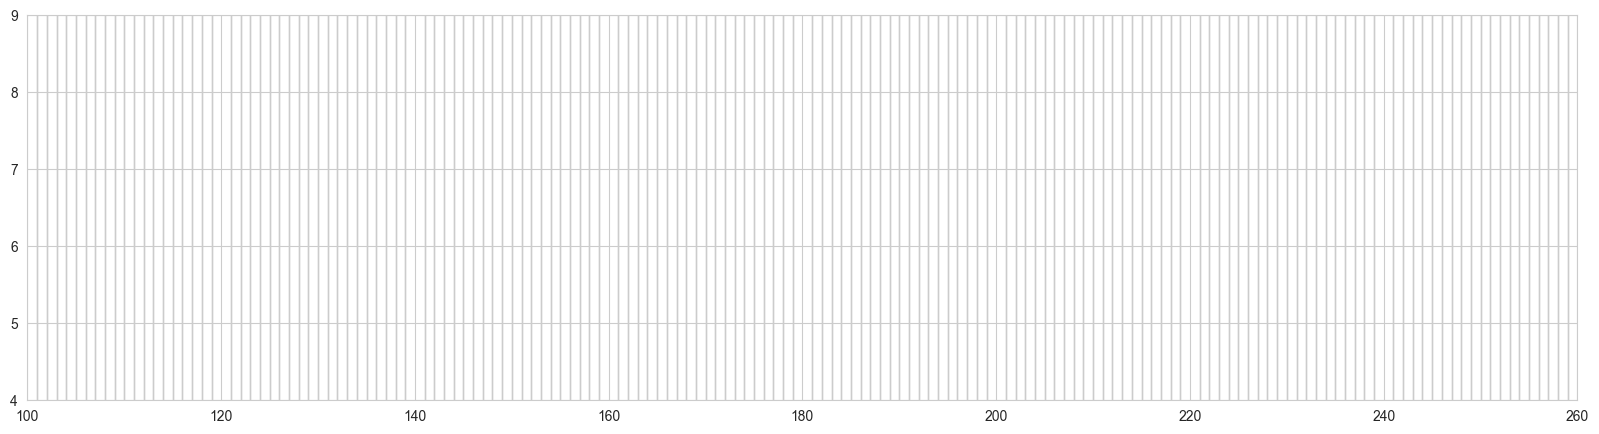

In [15]:
# Look at grid
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(pgrid.T[0] , minor=True)
ax.set_yticks(pgrid.T[1] , minor=True)
ax.set_xlim(100,260)
ax.set_ylim(4,9)
ax.grid(True, which='both')
plt.savefig('gridx.jpg', dpi=200);


In [16]:
# Bulid numpy grid from 100 to 260, against 4 to 9, in steps of 1
pgrid = np.mgrid[100:260:1, 4:10:1].reshape(2,-1).T
pgrid

array([[100,   4],
       [100,   5],
       [100,   6],
       ...,
       [259,   7],
       [259,   8],
       [259,   9]])

Let's start with the priors and calcualte their likelihoods (confusing name alert), starting with the first two pairs of values on the grid

In [17]:
# Calculate prior likelihood for first pair of values on the grid
sp.stats.norm.logpdf(pgrid[0,0], loc=178, scale=20), sp.stats.uniform.logpdf(pgrid[0,1], loc=0, scale=50)

(-11.519670806758663, -3.912023005428146)

In [18]:
sp.stats.norm.logpdf(pgrid[0,0], loc=178, scale=20)+sp.stats.uniform.logpdf(pgrid[0,1], loc=0, scale=50)

-15.43169381218681

In [19]:
# Calculate prior likelihood for second pair of values on the grid
sp.stats.norm.logpdf(pgrid[1,0], loc=178, scale=20), sp.stats.uniform.logpdf(pgrid[1,1], loc=0, scale=50)

(-11.519670806758663, -3.912023005428146)

In [20]:
# Calculate prior likelihood for last pair of values on the grid
sp.stats.norm.logpdf(pgrid[-1,0], loc=178, scale=20), sp.stats.uniform.logpdf(pgrid[-1,1], loc=0, scale=50)

(-12.115920806758663, -3.912023005428146)

In [21]:
# Sum
sp.stats.norm.logpdf(pgrid[-1,0], loc=178, scale=20)+ sp.stats.uniform.logpdf(pgrid[-1,1], loc=0, scale=50)

-16.02794381218681

In [22]:
# Calculate priors
prior_loglike = sp.stats.norm.logpdf(pgrid[:,0], loc=178, scale=20) + sp.stats.uniform.logpdf(pgrid[:,1], loc=0, scale=50)
prior_loglike

array([-15.43169381, -15.43169381, -15.43169381, -15.43169381,
       -15.43169381, -15.43169381, -15.23794381, -15.23794381,
       -15.23794381, -15.23794381, -15.23794381, -15.23794381,
       -15.04669381, -15.04669381, -15.04669381, -15.04669381,
       -15.04669381, -15.04669381, -14.85794381, -14.85794381,
       -14.85794381, -14.85794381, -14.85794381, -14.85794381,
       -14.67169381, -14.67169381, -14.67169381, -14.67169381,
       -14.67169381, -14.67169381, -14.48794381, -14.48794381,
       -14.48794381, -14.48794381, -14.48794381, -14.48794381,
       -14.30669381, -14.30669381, -14.30669381, -14.30669381,
       -14.30669381, -14.30669381, -14.12794381, -14.12794381,
       -14.12794381, -14.12794381, -14.12794381, -14.12794381,
       -13.95169381, -13.95169381, -13.95169381, -13.95169381,
       -13.95169381, -13.95169381, -13.77794381, -13.77794381,
       -13.77794381, -13.77794381, -13.77794381, -13.77794381,
       -13.60669381, -13.60669381, -13.60669381, -13.60

We typically call these values the **prior probabilty** (likelihood here though, as we haven't standardized), so what do they look like?

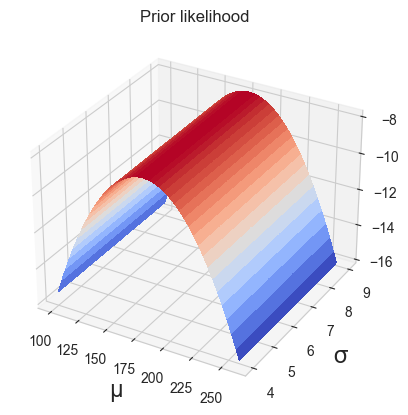

In [23]:
# Grab range of values across full range of grid for mu and sigma
xi = np.linspace(pgrid[:,0].min(), pgrid[:,0].max(), 100)
yi = np.linspace(pgrid[:,1].min(), pgrid[:,1].max(), 100)
# Interpolate prior values across grid given the ranges above
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Create a mu by sigma grid
X = np.arange(100, 260, 1)
Y = np.arange(4, 10, 1)
X, Y = np.meshgrid(X, Y)
# Calculate prior likelihood on grid
Z = sp.stats.norm.logpdf(X, loc=178, scale=20) + sp.stats.uniform.logpdf(Y, loc=0, scale=50)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Contour plot of results
#plt.contour(xi, yi, zi)
plt.xlabel('μ', fontsize=17)
plt.ylabel('σ', fontsize=17)
plt.title('Prior likelihood')
plt.savefig('priors.jpg', dpi=200);

We get a flat top because in the σ dimension we have a uniform distribution; although odd, this is a 'heat' contour, so it's 'red hot' peak is at 178, regardless of the value of σ.

Ok, we have the prior likelihood, now we need the data likelihood - substituting in the grid pair values for the mean and standard deviation for each recorded height. Let's start with the first pair on the grid and the first height value:

In [24]:
xdata.height.values[0]

151.765

In [25]:
sp.stats.norm.logpdf(kdata.height.values[0], loc=pgrid[:,0][0], scale=pgrid[:,1][0])

-86.04320867557452

In [26]:
# Calculate for first pair of values on the grid
sum(sp.stats.norm.logpdf(kdata.height, loc=pgrid[:,0][0], scale=pgrid[:,1][0]))

-34258.21725461854

In [27]:
# Calculate for last pair of values on the grid
sum(sp.stats.norm.logpdf(kdata.height, loc=pgrid[:,0][-1], scale=pgrid[:,1][-1]))

-24910.64651383706

In [28]:
# Calculate likelihood (data distribution) for a normal (on the log scale) for each point in the grid using the stats part of scipy, 
# which uses location for mean, and scale for SD (due to lots of ML people using scipy)
log_likelihood = np.array([sum(sp.stats.norm.logpdf(kdata.height, loc=pgrid[:,0][i], scale=pgrid[:,1][i])) for i in range(len(pgrid))])
log_likelihood

-15083631.095292073

And we can take a look at the **likelihood surface**, which is where frequentist analysis stops 

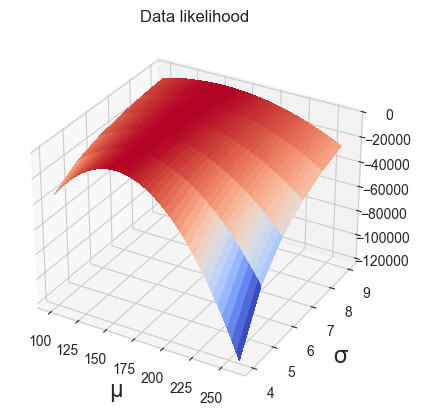

In [29]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Grab range of values across full range of grid for mu and sigma
xi = np.linspace(pgrid[:,0].min(), pgrid[:,0].max(), 100)
yi = np.linspace(pgrid[:,1].min(), pgrid[:,1].max(), 100)

# Calculate data likelihood on grid
Zll = np.array([[sum(sp.stats.norm.logpdf(kdata.height, loc=x_, scale=y_)) for x_,y_ in zip(x,y)] for x,y in zip(X,Y)])

# Plot the surface.
surf = ax.plot_surface(X, Y, Zll, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel('μ', fontsize=17)
plt.ylabel('σ', fontsize=17)
plt.title('Data likelihood')
plt.savefig('likelihood_surface.jpg', dpi=200);

In [30]:
# Maximum likelihood estimate
pgrid[log_likelihood==max(log_likelihood)], max(log_likelihood)

(array([[155,   8]]), -1220.25308968841)

Now that we have log-scale data likelhood and prior probability values, we can **add** them together to calculate the numerator of Bayes theorem:

$$
\text{Posterior} = \frac{\text{likelihood x prior}}{\text{normalizing constant}}
$$

In [31]:
# Un-normalized posterior
post_num = log_likelihood + prior_loglike

In [47]:
# Normalized posterior - remember we're doing log-probability calculations here, so don't foget to exponentiate!
# Also in log-land, the division becomes subtraction, and the normalization is relative to the largst value (for plotting)
posterior = np.exp(post_num - max(post_num))

1.609694356366015

With this, we can take a look at what the posterior surface looks like:

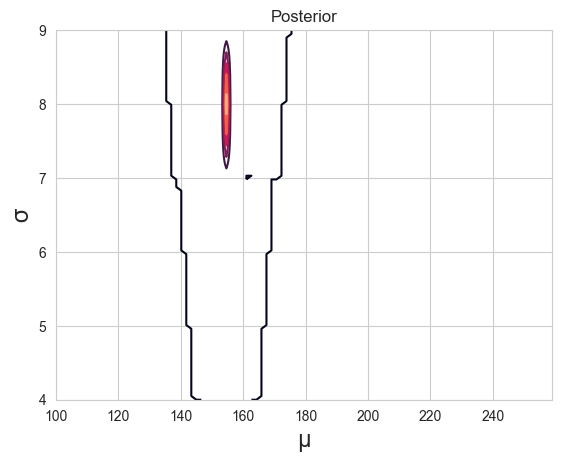

In [33]:
# Grab range of values across full range of grid for mu and sigma
xi = np.linspace(pgrid[:,0].min(), pgrid[:,0].max(), 100)
yi = np.linspace(pgrid[:,1].min(), pgrid[:,1].max(), 100)
# Interpolate prior values across grid given the ranges above
zi = griddata((pgrid[:,0], pgrid[:,1]), posterior, (xi[None,:], yi[:,None]))
# Contour plot of results
plt.contour(xi, yi, zi)
plt.xlabel('μ', fontsize=17)
plt.ylabel('σ', fontsize=17)
plt.title('Posterior')
plt.savefig('posterior.jpg', dpi=200);

Let's zoom in

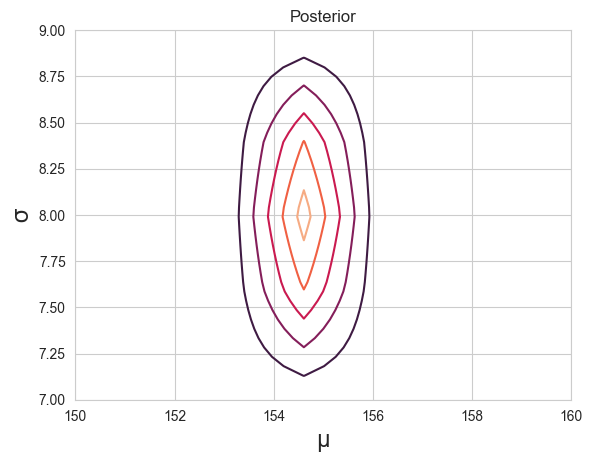

In [34]:
# Grab range of values across full range of grid for mu and sigma
xi = np.linspace(pgrid[:,0].min(), pgrid[:,0].max(), 100)
yi = np.linspace(pgrid[:,1].min(), pgrid[:,1].max(), 100)
# Interpolate prior values across grid given the ranges above
zi = griddata((pgrid[:,0], pgrid[:,1]), posterior, (xi[None,:], yi[:,None]))
# Contour plot of results
plt.contour(xi, yi, zi)
plt.xlabel('μ', fontsize=17)
plt.ylabel('σ', fontsize=17)
plt.xlim(150,160)
plt.ylim(7,9)
plt.title('Posterior')

plt.savefig('posterior_zoom.jpg', dpi=200);

So this is what's known as the **joint posterior** density for μ and σ, evaluated using grid approximation. 

So congradulations - we've calcualted the mean and standard deviation of some data, but in a really important way (*i.e.* using Bayes theorem). It's important to keep in mind that while means and variacnes are things we can easily calculate using math (hence their widespread use), they still constitute a fully Bayesian model for the height data. **Plus** we get uncertainty estimates for μ and σ, which is important. 

Next we'll add some complexity to our model - a covariate of weight - to do what a more typical kind of linear regression. First, let's see what sort of relationship we have between these variables:

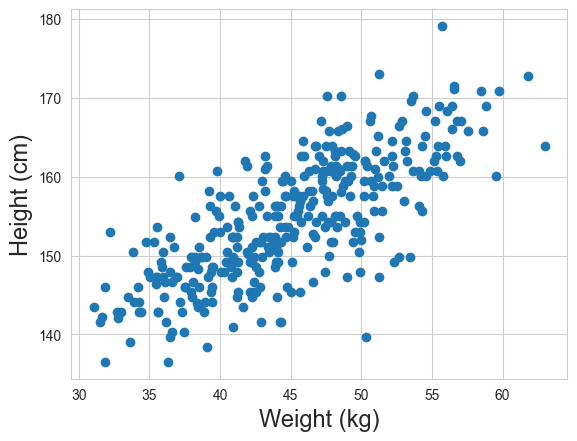

In [35]:
plt.scatter(kdata.weight, kdata.height)
plt.xlabel('Weight (kg)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17)
plt.savefig('scatter.jpg', dpi=200);

Ok, looks linear enough. Now let's write out a linear model for this:

$$
\large{
\begin{align*}
h_i &\sim N(\mu_i,\sigma) \\
\mu_i &= \beta_0 + \beta_1(x_i - \bar{x}) \\
\beta_0 &\sim N(178,20) \\
\beta_1 &\sim N(0,10) \\
\sigma &\sim U(0, 50)
\end{align*}}
$$

So, as before, let's simulate and see if we have reasonable priors. This time we are simulating possible lines to describe the relationship between weight and height.

In [36]:
# Number of samples
nsamp = 100
# Intercept - estimated height at popultion average weight
β0_ = np.random.normal(178, 20, nsamp)
# Slope - relationship between weight and height
β1_ = np.random.normal(0, 10, nsamp)

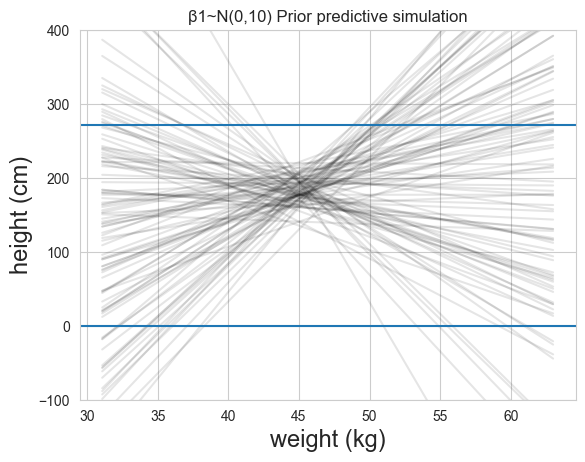

In [37]:
# Grab range of weights to plot over
meanweight = np.mean(kdata.weight)
weights_ = np.linspace(min(kdata.weight),max(kdata.weight),50)-meanweight

# Plot resulting lines given sample values for β0 and β1, using a list comprehension
[plt.plot(weights_+meanweight, b0+b1*weights_, c='black', alpha=0.1) for b0,b1 in zip(β0_,β1_)]

# Add min and max human heights
plt.axhline(272)
plt.axhline(0)

# Make it look nice
plt.ylim(-100,400)
plt.xlabel('weight (kg)', fontsize=17)
plt.ylabel('height (cm)', fontsize=17)
plt.title('β1~N(0,10) Prior predictive simulation')
plt.savefig('priorPlinear.jpg', dpi=200);

So we know that people can't be less than zero or more than 272 cm tall, so our model is a priori quite wrong, and we have the opportunity to do a bit better, using our 'domain knowledge' (external information, expertise, common sense etc.) to do a bit better. Given that we know that the relationship between weight and height in people is positive, we can do a bit better. McElreath suggests a log-normal prior because it is by definition constrained to be above zero. Let's try a $log-Normal(0, 1)$ prior and see what happens:

In [38]:
# New slope prior for the relationship between weight and height
β1_ = np.random.lognormal(0, 1, nsamp)

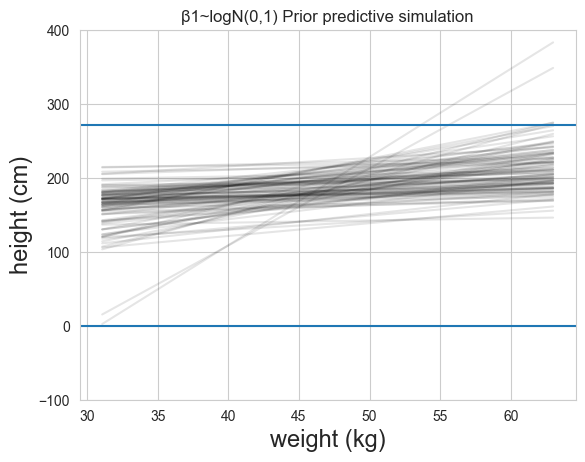

In [39]:
# Plot new lines given sample values for β0 and β1, using a list comprehension
[plt.plot(weights_+meanweight, b0+b1*weights_, c='black', alpha=0.1) for b0,b1 in zip(β0_,β1_)]

# Add min and max human heights
plt.axhline(272)
plt.axhline(0)

# Make it look nice
plt.ylim(-100,400)
plt.xlabel('weight (kg)', fontsize=17)
plt.ylabel('height (cm)', fontsize=17)
plt.title('β1~logN(0,1) Prior predictive simulation')
plt.savefig('priorPlinear2.jpg', dpi=200);

So while there are some extreme values still possible for max heights, the lower values are constrained to be positive, which is much better. Incidentally plotting a hundred or more lines from some distribtuion is a very Bayesian way to get a look at uncertainty - they tend to illustrate odd cases such as above and are **way** easier to plot than formal uncertainty intervals (credible intervals) around the mean trendline.

With reasonable priors in hand we can now use the quadratic approximation to calculate our posteriors:

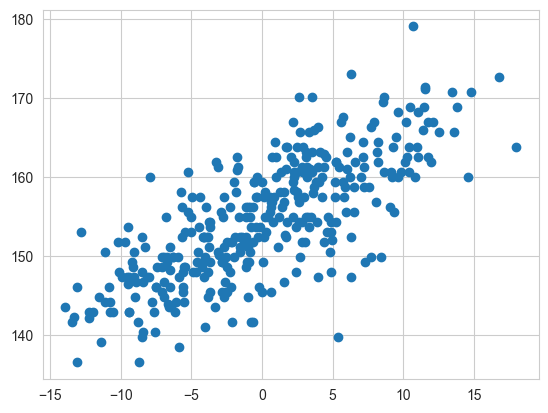

In [40]:
plt.scatter(kdata.weight.values-meanweight,kdata.height.values)

In [41]:
# Sampling using MCMC in PyMC
with pm.Model() as kalahari2:
    # Priors
    β0 = pm.Normal('Average_height', 178, 20)
    β1 = pm.Lognormal('Weight_slope', 0, 1)
    σ = pm.Uniform('Obs_sd', 0, 50)
    
    # Linear model
    μ = β0+β1*(kdata.weight.values-meanweight)
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=kdata.height.values)
    
    trace_k = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Average_height, Weight_slope, Obs_sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


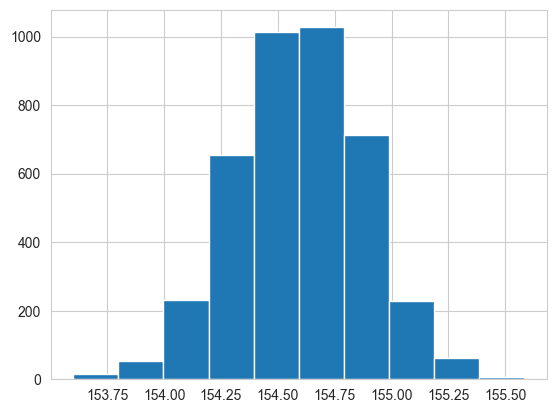

In [42]:
plt.hist(trace_k.posterior.Average_height.values.flatten());

In [43]:
# Grab median value from the posterior of average height
b0 = trace_k.posterior.Average_height.median().values
# Grab median value from the posterior of the effect of weight on height
b1 = trace_k.posterior.Weight_slope.median().values
# Grab median value from the posterior of the variability around the line
sig = trace_k.posterior.Obs_sd.median().values

So we have some parameter estimates, lets see how this fits to our data:

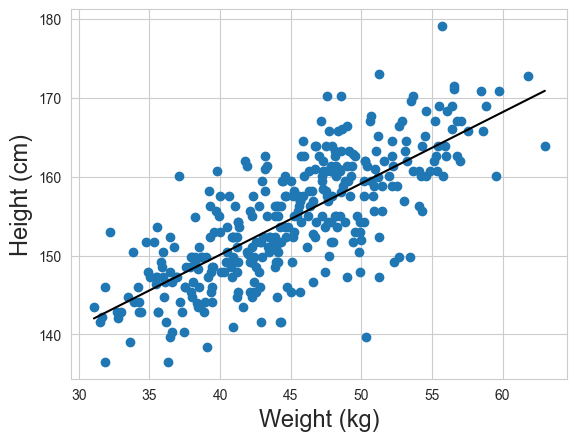

In [44]:
plt.scatter(kdata.weight, kdata.height)
plt.plot(weights_+meanweight, b0+b1*weights_, c='black')
plt.xlabel('Weight (kg)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17)
plt.savefig('fitline.jpg', dpi=200);

Looks not too bad, how about those uncertainty bounds?

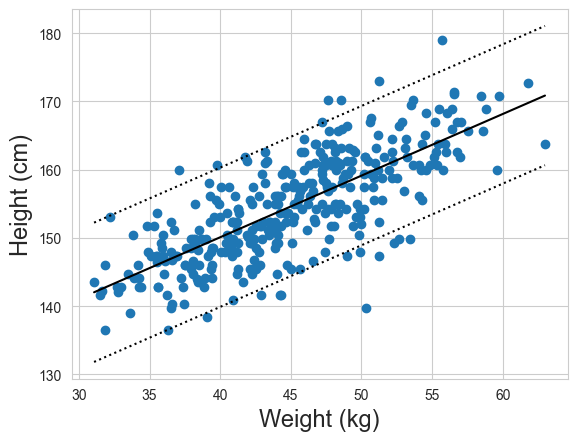

In [45]:
plt.scatter(kdata.weight, kdata.height)
y_ = b0+b1*weights_
y_uu = y_+sig*2
y_ul = y_-sig*2
plt.plot(weights_+meanweight, y_, c='black')
plt.plot(weights_+meanweight, y_uu, ":", c='black')
plt.plot(weights_+meanweight, y_ul, ":", c='black')
plt.xlabel('Weight (kg)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17)
plt.savefig('fitlines.jpg', dpi=200);

And what do those uncertainty bounds represent?

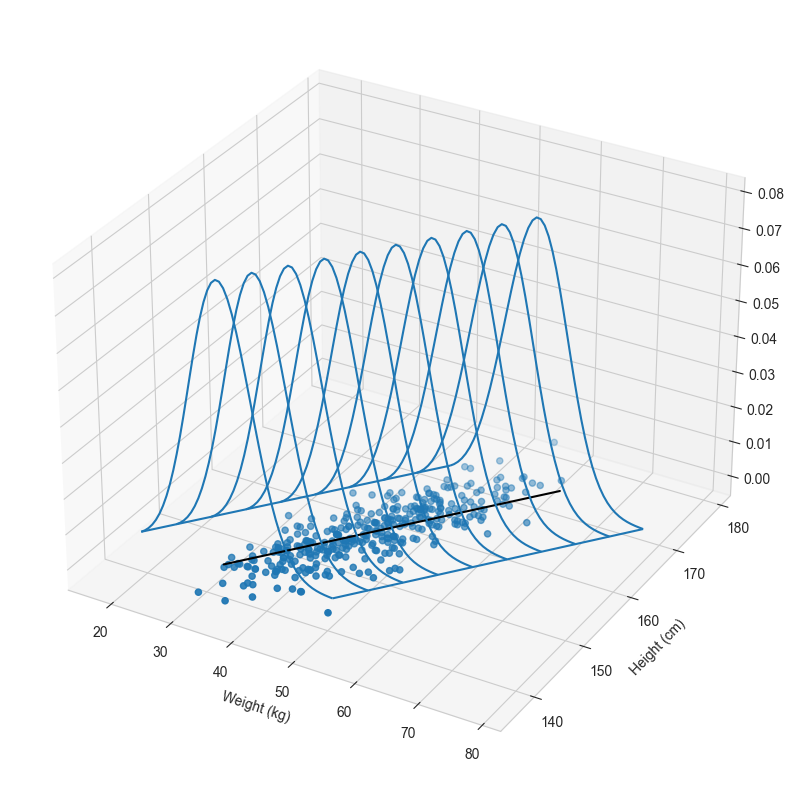

In [46]:
# Create wireframe positions
sx = weights_.size
# Grab every 5th element in ynew
yrangex = y_[::5]
sy = yrangex.size
xnew_w = np.tile(weights_, (sy, 1))
ynew_w = np.tile(yrangex, (sx, 1)).T

# Wireframe lines
Z = sp.stats.norm.pdf(xnew_w,loc=0,scale=sig)

# Figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection='3d')
surf = ax.plot_wireframe(xnew_w+((ynew_w-b0)/b1)+meanweight, ynew_w, Z, cstride=1000)
ax.scatter(kdata.weight, kdata.height)
ax.plot(weights_+meanweight, y_, c='black')
ax.set_xlabel('Weight (kg)')
ax.set_ylabel('Height (cm)')
plt.savefig('wireframe.jpg', dpi=200);

Et voilà! We have fit our second Bayesian linear regression model (the first that looks like a line). You should feel proud, this is a big foundation on which to build your skilz.